# DATASET PREPROCESSING


In [1]:
# Useful libraries

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import datetime as dt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score, classification_report
from sklearn.tree import DecisionTreeClassifier

In [2]:
df1 = pd.read_csv("Fraud_Data.csv")
ip_country = pd.read_csv("IpAddress_to_Country.csv")

In [3]:
df1.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0


In [4]:
ip_country.head()

,lower_bound_ip_address,upper_bound_ip_address,country
0,16777216.0,16777471,Australia
1,16777472.0,16777727,China
2,16777728.0,16778239,China
3,16778240.0,16779263,Australia
4,16779264.0,16781311,China


## PART I. VISUALIZATION DATASET

### 1) DATASET DESCRIPTION

In [5]:
#Describe the dataset and look for missing values

display(df1.describe(include = "all"))
df1.isna().sum()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class
count,151112.000000,151112,151112,151112.000000,151112,151112,151112,151112,151112.000000,1.511120e+05,151112.000000
unique,NaN,151112,150679,NaN,137956,3,5,2,NaN,NaN,NaN
top,NaN,2015-07-12 04:14:56,2015-07-17 23:22:55,NaN,ITUMJCKWEYNDD,SEO,Chrome,M,NaN,NaN,NaN
freq,NaN,1,3,NaN,20,60615,61432,88293,NaN,NaN,NaN
mean,200171.040970,NaN,NaN,36.935372,NaN,NaN,NaN,NaN,33.140704,2.152145e+09,0.093646
std,115369.285024,NaN,NaN,18.322762,NaN,NaN,NaN,NaN,8.617733,1.248497e+09,0.291336
min,2.000000,NaN,NaN,9.000000,NaN,NaN,NaN,NaN,18.000000,5.209350e+04,0.000000
25%,100642.500000,NaN,NaN,22.000000,NaN,NaN,NaN,NaN,27.000000,1.085934e+09,0.000000
50%,199958.000000,NaN,NaN,35.000000,NaN,NaN,NaN,NaN,33.000000,2.154770e+09,0.000000
75%,300054.000000,NaN,NaN,49.000000,NaN,NaN,NaN,NaN,39.000000,3.243258e+09,0.000000


user_id           0
signup_time       0
purchase_time     0
purchase_value    0
device_id         0
source            0
browser           0
sex               0
age               0
ip_address        0
class             0
dtype: int64

In [6]:
df1['class'].value_counts()

0    136961
1     14151
Name: class, dtype: int64

### 2) CREATING NEW VARIABLES

In [7]:
# Creating the country variable according to the IP Adress of the buyer
def country_ip(ip): 
    try:
        return ip_country["country"][(ip_country["lower_bound_ip_address"] <= ip) & (ip <= ip_country["upper_bound_ip_address"])].iloc[0]
    except IndexError:
        return "Unknown country"

df1["country"] = df1["ip_address"].apply(country_ip)

In [8]:
df1.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,Unknown country
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,United States


In [9]:
# Creating time delta between signing up time and purchasing time

df1["purchase_time"] = pd.to_datetime(df1["purchase_time"])
df1["signup_time"] = pd.to_datetime(df1["signup_time"])

df1["time_delta"] = (df1["purchase_time"] - df1["signup_time"])// np.timedelta64(1, 's')

In [10]:
# Extracting the Year and Month from the timedelta

df1['year'] = pd.DatetimeIndex(df1['purchase_time']).year
df1['month'] = pd.DatetimeIndex(df1['purchase_time']).month

df1.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country,time_delta,year,month
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan,4506682,2015,4
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States,17944,2015,6
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States,1,2015,1
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,Unknown country,492085,2015,5
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,United States,4361461,2015,9


In [11]:
# Dropping columns that won't be necessary for model building because there is too many different values

to_drop = ['user_id','signup_time',"purchase_time", "device_id","ip_address", "time_delta"]
df2 = df1.drop(to_drop, axis = 1)
df2

,purchase_value,source,browser,sex,age,class,country,year,month
0,34,SEO,Chrome,M,39,0,Japan,2015,4
1,16,Ads,Chrome,F,53,0,United States,2015,6
2,15,SEO,Opera,M,53,1,United States,2015,1
3,44,SEO,Safari,M,41,0,Unknown country,2015,5
4,39,Ads,Safari,M,45,0,United States,2015,9
...,...,...,...,...,...,...,...,...,...
151107,43,SEO,Chrome,M,28,1,United States,2015,3
151108,35,SEO,Safari,M,32,0,Netherlands,2015,5
151109,40,SEO,IE,F,26,0,Japan,2015,5
151110,46,SEO,Chrome,M,37,0,United States,2015,9


In [12]:
df2.describe(include = 'all')

,purchase_value,source,browser,sex,age,class,country,year,month
count,151112.000000,151112,151112,151112,151112.000000,151112.000000,151112,151112.0,151112.000000
unique,NaN,3,5,2,NaN,NaN,182,NaN,NaN
top,NaN,SEO,Chrome,M,NaN,NaN,United States,NaN,NaN
freq,NaN,60615,61432,88293,NaN,NaN,58049,NaN,NaN
mean,36.935372,NaN,NaN,NaN,33.140704,0.093646,NaN,2015.0,6.008629
std,18.322762,NaN,NaN,NaN,8.617733,0.291336,NaN,0.0,2.660637
min,9.000000,NaN,NaN,NaN,18.000000,0.000000,NaN,2015.0,1.000000
25%,22.000000,NaN,NaN,NaN,27.000000,0.000000,NaN,2015.0,4.000000
50%,35.000000,NaN,NaN,NaN,33.000000,0.000000,NaN,2015.0,6.000000
75%,49.000000,NaN,NaN,NaN,39.000000,0.000000,NaN,2015.0,8.000000


In [13]:
# Dropping "year" column since it is always 2015

df2 = df2.drop("year", axis = 1)

In [14]:
# Looking deeper in the country column since there is a lot of unique values that might lower the performance of the model

country_count = df2["country"].value_counts()

country_count[country_count > 50].index.values

array(['United States', 'Unknown country', 'China', 'Japan',
       'United Kingdom', 'Korea Republic of', 'Germany', 'France',
       'Canada', 'Brazil', 'Italy', 'Australia', 'Netherlands',
       'Russian Federation', 'India', 'Taiwan; Republic of China (ROC)',
       'Mexico', 'Sweden', 'Spain', 'South Africa', 'Switzerland',
       'Poland', 'Argentina', 'Indonesia', 'Norway', 'Colombia', 'Turkey',
       'Viet Nam', 'Romania', 'Denmark', 'Hong Kong', 'Finland',
       'Austria', 'Ukraine', 'Chile', 'Belgium',
       'Iran (ISLAMIC Republic Of)', 'Egypt', 'Czech Republic',
       'Thailand', 'New Zealand', 'Israel', 'Saudi Arabia', 'Venezuela',
       'Ireland', 'European Union', 'Greece', 'Portugal', 'Hungary',
       'Malaysia', 'Singapore', 'Pakistan', 'Philippines', 'Bulgaria',
       'Morocco', 'Algeria', 'Peru', 'Tunisia', 'United Arab Emirates',
       'Ecuador', 'Seychelles', 'Lithuania', 'Kenya', 'Kazakhstan',
       'Kuwait', 'Costa Rica', 'Slovenia', 'Slovakia (SLOVAK R

In [15]:
# Keeping only the countries with more than 50 purchases

to_keep = country_count[country_count > 50].index.values

df2 = df2.loc[df2["country"].isin(to_keep), : ]


In [16]:
df2.head()

,purchase_value,source,browser,sex,age,class,country,month
0,34,SEO,Chrome,M,39,0,Japan,4
1,16,Ads,Chrome,F,53,0,United States,6
2,15,SEO,Opera,M,53,1,United States,1
3,44,SEO,Safari,M,41,0,Unknown country,5
4,39,Ads,Safari,M,45,0,United States,9


### 3) VARIABLES VISUALIZATION

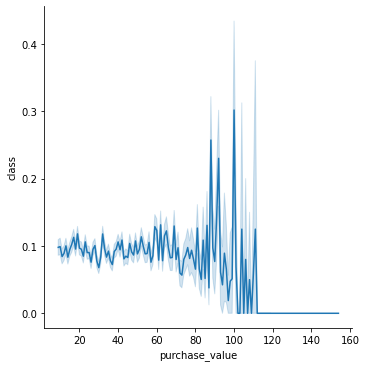

In [17]:
# Visualizing the relation between the purchase value and the fraud probability

sns.catplot(x = "purchase_value", y = "class", data = df2, kind = 'line')

/opt/conda/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='age', ylabel='Density'>

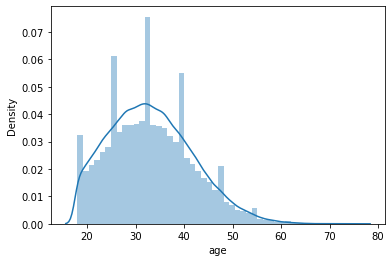

In [18]:
# Visualizing the age distribution

sns.distplot(df2["age"])

/opt/conda/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='purchase_value', ylabel='Density'>

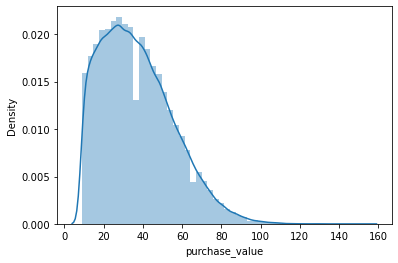

In [19]:
# Visualizing the purchase value distribution

sns.distplot(df2["purchase_value"])

### 3) SAVING NEW PROCESSED DATAFRAME FOR MODEL BUILDING

In [20]:
df2.to_csv("Dataset_for_model_building.csv", index = False)